# Detecting Naturalistic Gaze Coordination between M1 and M2

In this notebook, we attempt to quantitatively measure the gaze behavior displayed by M1 and M2 when they are made to sit facing each other and are allowed to freely direct their gaze anywhere they want. We want to investigate whether the resultant gaze patterns of the monkeys are independent of each other, or do they depend on the behavior of each other. As a first step, we measure the probability of M1 fixating at the `face`, `eyes`, `non_eye_face` area of M2 for each run and also for fixations `out_of_roi`. We calculate the same for M2 as well. Then for each of those ROIs, we count the number of time bins where both M1 and M2 are looking into the particular ROI, to estimate the probability of both of them displaying the particular fixation behavior. If the fixation patterns of M1 and M2 depend on each other for a type of fixation, then as a first-pass verification $$P(M1).P(M2) \neq P(M1\&M2)$$ should hold. Below are the code snippets to test that out.

Load the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from scipy.stats import wilcoxon
import pingouin as pg
import scipy.stats as stats
from random import sample

import load_data
import curate_data

Set up logging and params initializing function

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    handlers=[logging.StreamHandler()])
logger = logging.getLogger(__name__)

def _initialize_params():
    logger.info("Initializing parameters")
    params = {
        'reanalyse_fixation_probabilities': True
        }
    params = curate_data.add_root_data_to_params(params)
    params = curate_data.add_processed_data_to_params(params)
    logger.info("Parameters initialized successfully")
    return params

Load the dataframes with the eye-movement behavior related data and information about participating M1 and M2 monkeys for each session

In [3]:
params = _initialize_params()

eye_mvm_behav_df_file_path = os.path.join(
    params['processed_data_dir'], 'eye_mvm_behav_df.pkl'
)
monkeys_per_session_dict_file_path = os.path.join(
    params['processed_data_dir'], 'ephys_days_and_monkeys.pkl'
)

logger.info("Loading data files")
eye_mvm_behav_df = load_data.get_data_df(eye_mvm_behav_df_file_path)
monkeys_per_session_df = pd.DataFrame(load_data.get_data_df(monkeys_per_session_dict_file_path))
logger.info("Data loaded successfully")

2025-02-12 09:37:52,838 - __main__ - INFO - Initializing parameters
2025-02-12 09:37:52,838 - curate_data - INFO - Setting root data directory based on whether on the cluster or not and whether on Grace or Milgram.
2025-02-12 09:37:52,839 - curate_data - INFO - Root data directory set to: /gpfs/milgram/project/chang/pg496/data_dir/social_gaze/
2025-02-12 09:37:52,839 - curate_data - INFO - Processed data directory set to: /gpfs/milgram/project/chang/pg496/data_dir/social_gaze/intermediates
2025-02-12 09:37:52,839 - __main__ - INFO - Parameters initialized successfully
2025-02-12 09:37:52,839 - __main__ - INFO - Loading data files
2025-02-12 09:37:53,561 - __main__ - INFO - Data loaded successfully


Define functions to compute probabilities of M1 and M2 performing each type of fixation. So for each type of fixation, we get: $P(M1)$, $P(M2)$, $P(M1).P(M2)$, and $P(M1\&M2)$

In [4]:
def compute_fixation_statistics(eye_mvm_behav_df, monkeys_per_session_df):
    """Compute fixation probabilities and joint fixation probabilities for m1 and m2."""
    logger.info("Computing fixation statistics")
    joint_probs = []
    
    grouped = list(eye_mvm_behav_df.groupby(["session_name", "interaction_type", "run_number"]))
    for (session, interaction, run), sub_df in tqdm(grouped, desc="Processing sessions"):
        m1 = monkeys_per_session_df[monkeys_per_session_df["session_name"] == session]["m1"].iloc[0]
        m2 = monkeys_per_session_df[monkeys_per_session_df["session_name"] == session]["m2"].iloc[0]
        m1_df = sub_df[sub_df["agent"] == "m1"]
        m2_df = sub_df[sub_df["agent"] == "m2"]
        
        if m1_df.empty or m2_df.empty:
            continue
        
        m1_fixations = categorize_fixations(m1_df["fixation_location"].values[0])
        m2_fixations = categorize_fixations(m2_df["fixation_location"].values[0])
        run_length = m1_df["run_length"].values[0]
        
        for category in ["eyes", "non_eye_face", "face", "out_of_roi"]:
            if category != "face":
                m1_indices = [(start, stop) for cat, (start, stop) in zip(m1_fixations, m1_df["fixation_start_stop"].values[0]) if cat == category]
                m2_indices = [(start, stop) for cat, (start, stop) in zip(m2_fixations, m2_df["fixation_start_stop"].values[0]) if cat == category]
            else:
                m1_indices = [(start, stop) for cat, (start, stop) in zip(m1_fixations, m1_df["fixation_start_stop"].values[0]) if cat in {"eyes", "non_eye_face"}]
                m2_indices = [(start, stop) for cat, (start, stop) in zip(m2_fixations, m2_df["fixation_start_stop"].values[0]) if cat in {"eyes", "non_eye_face"}]
            
            joint_duration = compute_joint_duration(m1_indices, m2_indices)
            p_m1 = sum(stop + 1 - start for start, stop in m1_indices) / run_length
            p_m2 = sum(stop + 1 - start for start, stop in m2_indices) / run_length
            p_joint = joint_duration / run_length
            
            joint_probs.append({
                "monkey_pair": f"{m1}-{m2}",
                "session_name": session, "interaction_type": interaction, "run_number": run,
                "fixation_category": category, "P(m1)": p_m1, "P(m2)": p_m2,
                "P(m1)*P(m2)": p_m1 * p_m2, "P(m1&m2)": p_joint
            })

    logger.info("Fixation statistics computation complete")
    return pd.DataFrame(joint_probs)

def categorize_fixations(fix_locations):
    """Categorize fixation locations into predefined categories."""
    return [
        "eyes" if {"face", "eyes_nf"}.issubset(set(fixes)) else
        "non_eye_face" if set(fixes) & {"mouth", "face"} else
        "object" if set(fixes) & {"left_nonsocial_object", "right_nonsocial_object"} else "out_of_roi"
        for fixes in fix_locations
    ]

def compute_joint_duration(m1_indices, m2_indices):
    """Compute the overlapping duration between m1 and m2 fixation events."""
    m1_timepoints = set()
    for start, stop in m1_indices:
        m1_timepoints.update(range(start, stop + 1))

    m2_timepoints = set()
    for start, stop in m2_indices:
        m2_timepoints.update(range(start, stop + 1))
    
    joint_timepoints = m1_timepoints & m2_timepoints

    return len(joint_timepoints)

Now call the functions to calculate the probabilities

In [5]:
joint_probs_df = compute_fixation_statistics(eye_mvm_behav_df, monkeys_per_session_df)

2025-02-12 09:37:53,611 - __main__ - INFO - Computing fixation statistics
Processing sessions: 100%|██████████| 417/417 [00:08<00:00, 46.69it/s]
2025-02-12 09:38:02,554 - __main__ - INFO - Fixation statistics computation complete


Define functions for plotting the distribution of the probabilities of interest and performing relevant statistical tests to investigate a difference in their median values

In [6]:
def cliff_delta(x, y):
    """Compute Cliff's Delta effect size for two paired distributions."""
    n_x, n_y = len(x), len(y)
    diff_matrix = np.subtract.outer(x, y)
    num_greater = np.sum(diff_matrix > 0)
    num_smaller = np.sum(diff_matrix < 0)
    return (num_greater - num_smaller) / (n_x * n_y)

def bootstrap_power_wilcoxon(cat_data, num_bootstraps=1000, alpha=0.05):
    """Estimate power using bootstrapped Wilcoxon tests on paired data."""
    significant_count = 0
    for _ in range(num_bootstraps):
        resampled_data = cat_data.sample(n=len(cat_data), replace=True)  # Resample rows
        _, p = wilcoxon(resampled_data["P(m1)*P(m2)"], resampled_data["P(m1&m2)"])
        if p < alpha:
            significant_count += 1
    return significant_count / num_bootstraps

def plot_joint_fixation_distributions(joint_prob_df, params, group_by="monkey_pair", num_downsamples=100):
    """Generate subplot comparisons for fixation probability distributions, including non-parametric effect size and power estimation."""
    logger.info("Generating fixation probability plots with non-parametric power analysis")

    for grouping_name, sub_df in tqdm(joint_prob_df.groupby(group_by), desc=f"Plotting {group_by}"):
        fig, axes = plt.subplots(1, 4, figsize=(12, 5))  # 1 row, 4 columns layout
        categories = ["eyes", "non_eye_face", "face", "out_of_roi"]

        for i, category in enumerate(categories):
            cat_data = sub_df[sub_df["fixation_category"] == category]

            if not cat_data.empty:
                melted_data = cat_data.melt(id_vars=["fixation_category"],
                                            value_vars=["P(m1)*P(m2)", "P(m1&m2)"],
                                            var_name="Probability Type", value_name="Probability")

                # Wilcoxon test (on paired data)
                _, p_val_wilcoxon = wilcoxon(cat_data["P(m1)*P(m2)"], cat_data["P(m1&m2)"])

                # Compute Cliff's Delta for effect size
                effect_size_cliff = cliff_delta(cat_data["P(m1)*P(m2)"].values, cat_data["P(m1&m2)"].values)

                # Compute bootstrap-based power
                power = bootstrap_power_wilcoxon(cat_data)

                test_result_text = f"Wilcoxon p = {p_val_wilcoxon:.4f}\nCliff's Delta = {effect_size_cliff:.3f}\nPower (boot) = {power:.2f}"

                # Downsampling for "out_of_roi"
                if category == "out_of_roi":
                    min_sample_size = min(len(sub_df[sub_df["fixation_category"] == cat]) for cat in categories if cat != "out_of_roi")
                    downsampled_p_values = []
                    for _ in range(num_downsamples):
                        sampled_data = cat_data.sample(n=min_sample_size, replace=True)
                        _, p_ds = wilcoxon(sampled_data["P(m1)*P(m2)"], sampled_data["P(m1&m2)"])
                        downsampled_p_values.append(p_ds)

                    avg_p_downsampled = np.mean(downsampled_p_values)
                    test_result_text += f"\nDownsampled Wilcoxon p = {avg_p_downsampled:.4f}"

                # Plot
                sns.violinplot(data=melted_data, x="Probability Type", y="Probability", ax=axes[i], hue="Probability Type")
                axes[i].set_title(f"{category} Fixation Probabilities")
                axes[i].text(0.5, 0.9, test_result_text, ha='center', va='center', 
                             transform=axes[i].transAxes, fontsize=8)

        plt.suptitle(f"{group_by.capitalize()}: {grouping_name} Fixation Probability Distributions")
        plt.tight_layout()
        plt.show()

Generate the plots

2025-02-12 09:38:02,655 - __main__ - INFO - Generating fixation probability plots with non-parametric power analysis
Plotting monkey_pair:   0%|          | 0/6 [00:00<?, ?it/s]

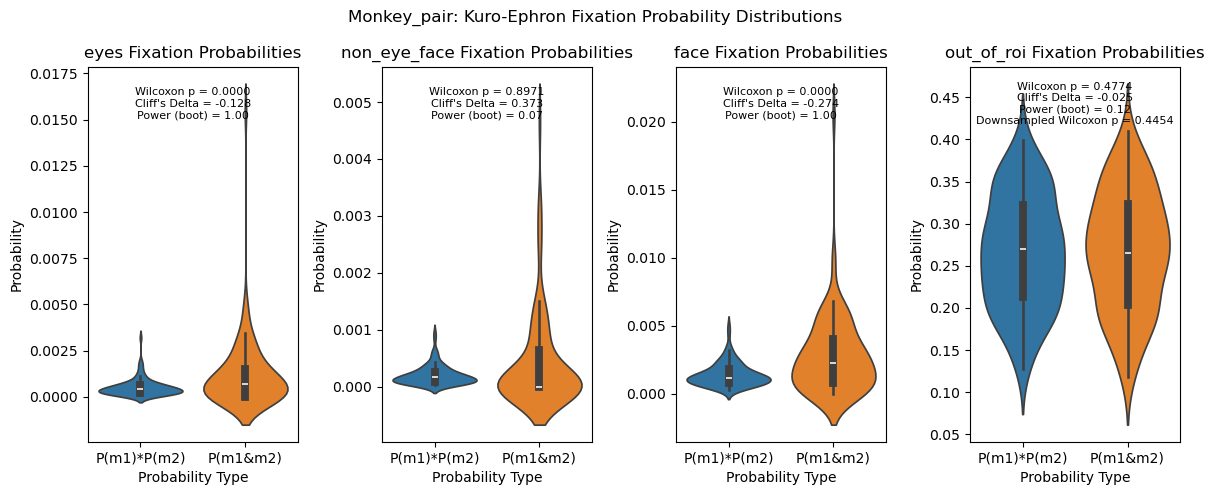

Plotting monkey_pair:  17%|█▋        | 1/6 [00:03<00:16,  3.22s/it]

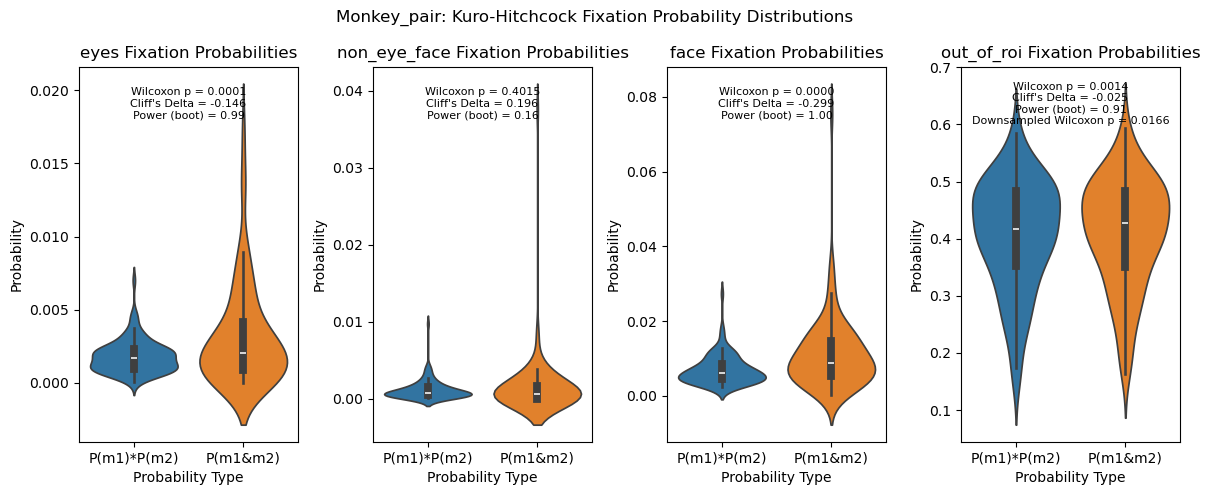

Plotting monkey_pair:  33%|███▎      | 2/6 [00:06<00:12,  3.18s/it]

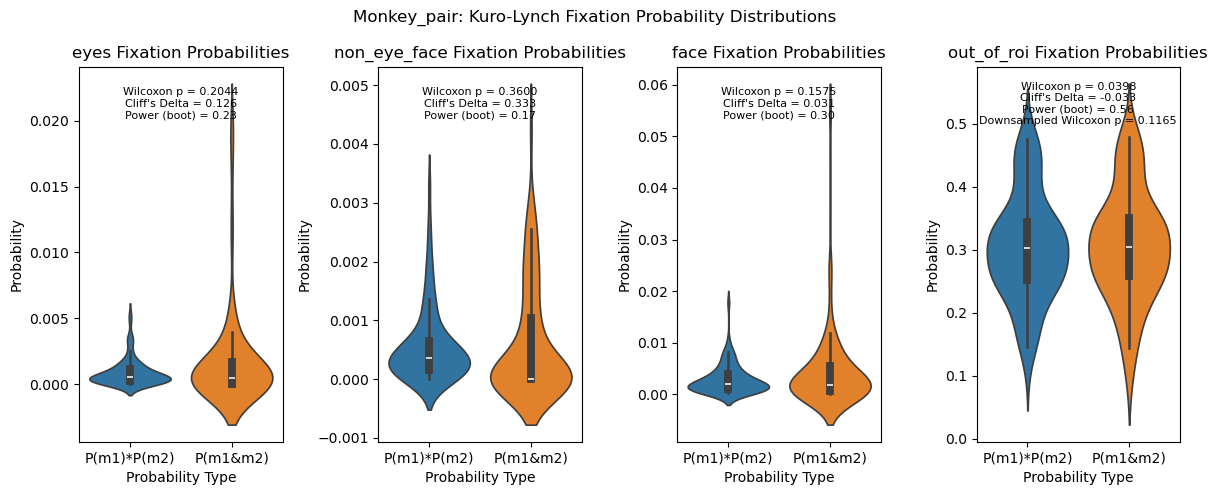

Plotting monkey_pair:  50%|█████     | 3/6 [00:09<00:09,  3.18s/it]

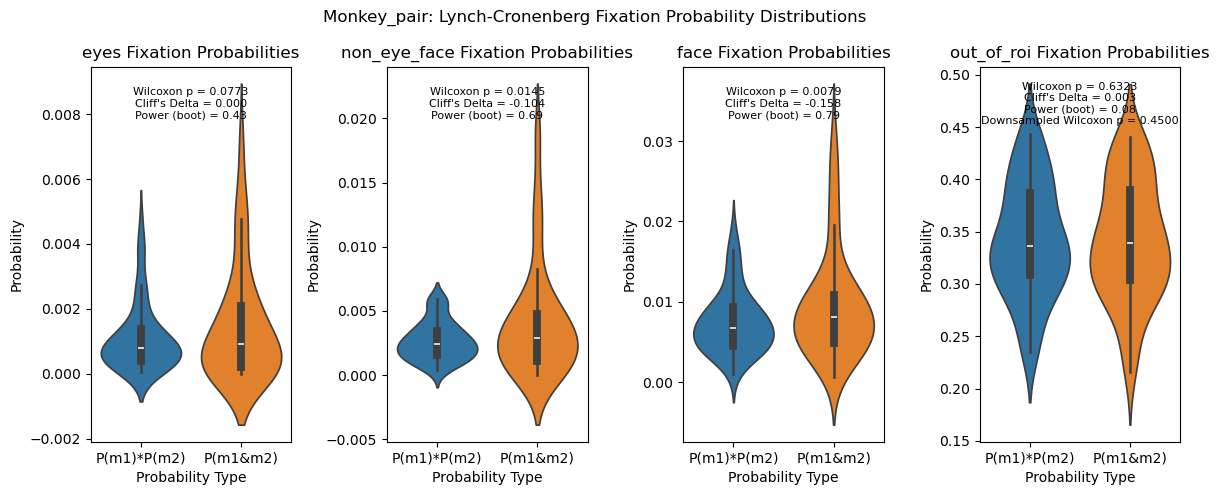

Plotting monkey_pair:  67%|██████▋   | 4/6 [00:12<00:06,  3.16s/it]

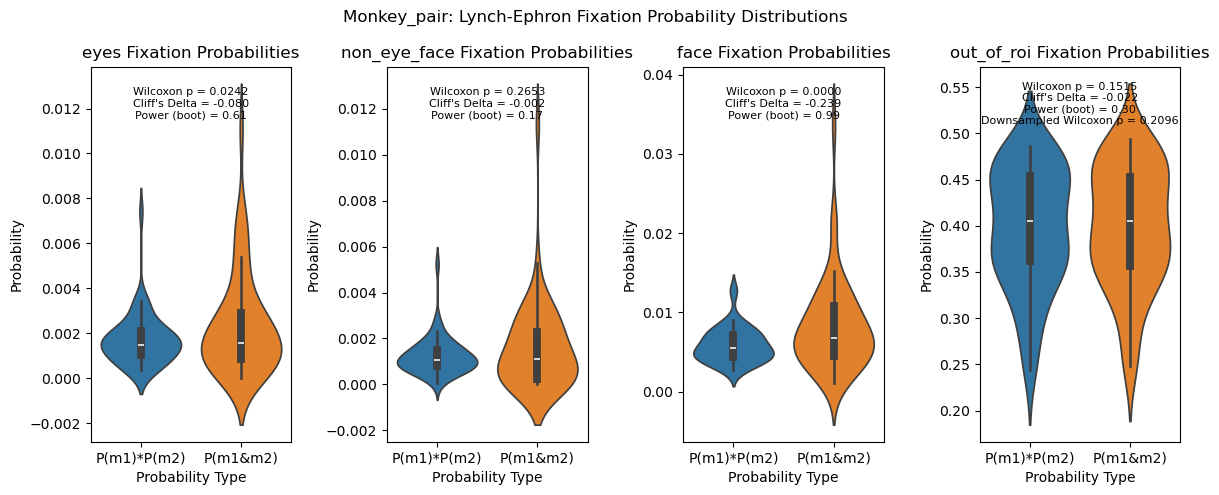

Plotting monkey_pair:  83%|████████▎ | 5/6 [00:16<00:03,  3.36s/it]

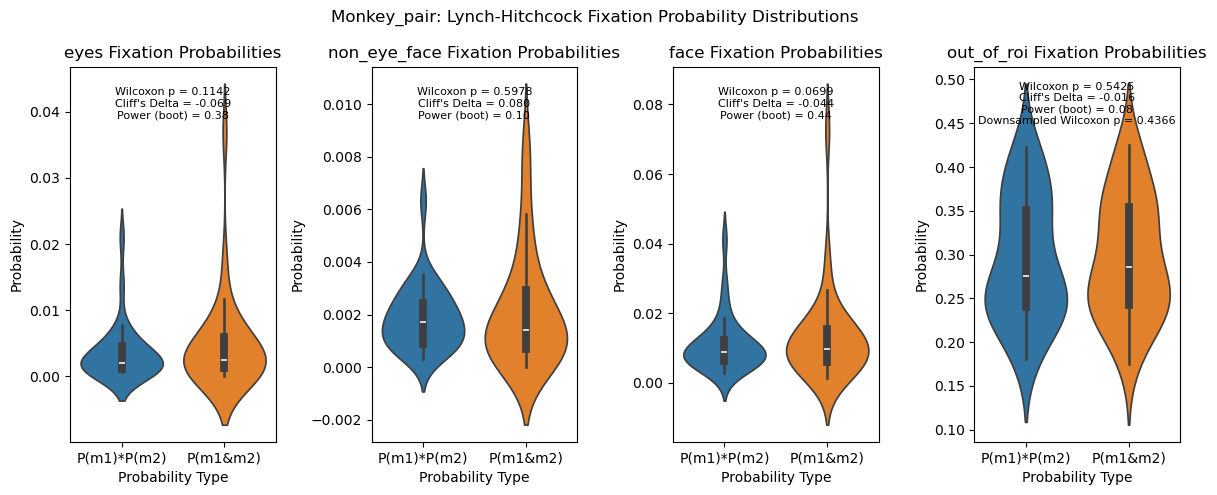

Plotting monkey_pair: 100%|██████████| 6/6 [00:19<00:00,  3.30s/it]


In [7]:
plot_joint_fixation_distributions(joint_probs_df, params, group_by="monkey_pair")

As we can observe, for most pairs of monkeys, fixations into each-others `face` region are not independent of each other. Time periods where both M1 and M2 are looking at each others face occur more frequently than one would expect from just the probability of M1 looking at M2's face and M2 looking at M1's face.